# Diamond EP Grouping by Resolution Limit

Previously the data was grouped by spacegroups, and different clusters of high to null success rates were found. Each spacegroup yielded different predictive performance, which was better for higher success rate clusters.

However, the data remains largely overlapped/unclear. Hopefully, grouping it by different resolution limits will result in an improvement.

In [1]:
import sys
dirpath = r'/home/ynk78583/PycharmProjects/Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
plt.style.use("ggplot")

Dials


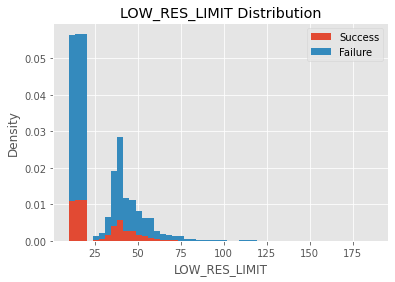

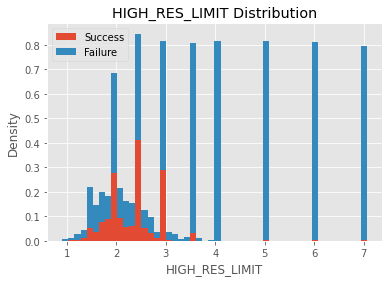

------------------------------------------------------------
3Dii


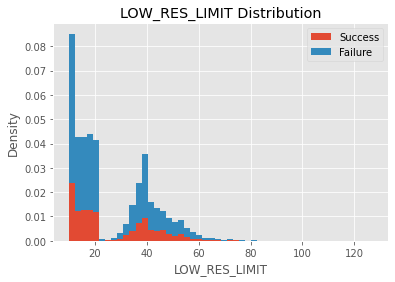

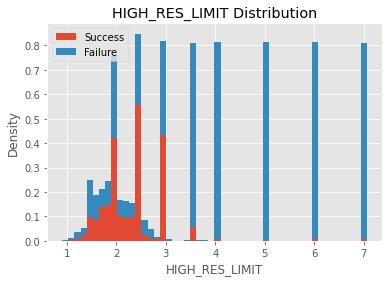

------------------------------------------------------------


In [2]:
for k, v in data.items():
    print(k.title())
    x, y = v.unpack()
    
    # separate success/failure
    mask_win, mask_lose = y == 1, y == 0
    x_win, x_lose = x[mask_win], x[mask_lose]

    # show resolutions distribution
    for col_name in ["LOW_RES_LIMIT", "HIGH_RES_LIMIT"]:
        # create stacked histograms
        fig, ax = plt.subplots()
        ax.hist([x_win[col_name], x_lose[col_name]], bins=50, stacked=True,
                density=True, label=["Success", "Failure"])

        # Aesthetics
        ax.set_xlabel(col_name)
        ax.set_ylabel("Density")
        ax.set_title(f"{col_name} Distribution")
        ax.legend()

        plt.show()
    
    print("-"*60)

- **Low Resolution Limit**: Largely distributed on the <25 area (equal on this area). Seemingly normal distribution focused on ~40.
- **High Resolution Limit**: Multiple discrete values (2, 2.5, 3, 3.5, 4, 5, 6 and 7). Smaller seemingly normal distribution around 2. Success mainly for <= 3 (fail otherwise).

When the data was downscaled for this experiment, it was done so in the following discrete values:

- **Low Resolution Limit**: None, 80, 60, 40, 20, 18, 16, 14, 12, 10
- **High Resolution Limit**: None, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7

Where None indicates the resolution was not cut. As such, we will group the data into every combination of these values as analyse it to identify the optimal resolution range.

Dials


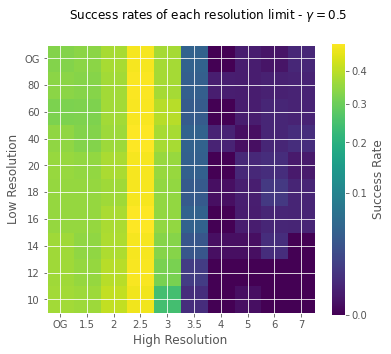

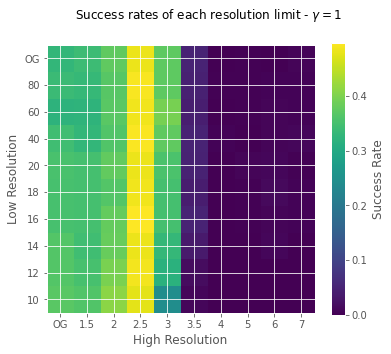

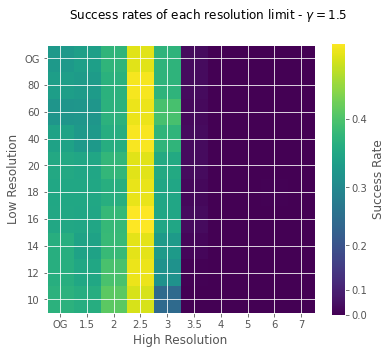

------------------------------------------------------------
3Dii


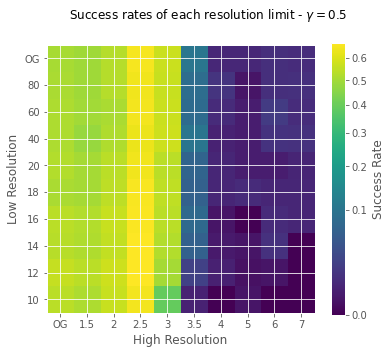

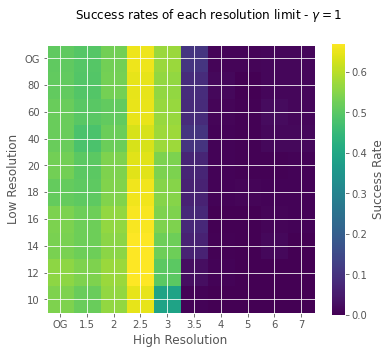

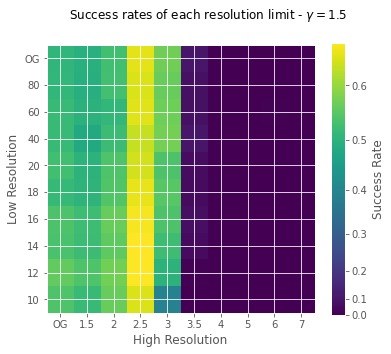

------------------------------------------------------------


In [3]:
from grouping import GroupedData
from warnings import warn
from matplotlib.colors import PowerNorm



for db_kind, datum in data.items():
    print(db_kind.title())
    x, y = datum.unpack()
    
    # group data
    groups = GroupedData(x, y)
    groups.group(x["DATASET_NAME"])
    
    # sort groups
    names = x["DATASET_NAME"].unique().tolist()
    names.sort()
    groups.sort(names, inplace=True)
    
    # get low/high resolution limits
    res_map = x[["DATASET_NAME", "RESOLUTION_LOW", "RESOLUTION_HIGH"]]
    res_map.set_index("DATASET_NAME", inplace=True)
    
    # to store success rates in [low_res, high_res] dataframe
    success_rates = []
    
    # for every low/high resolution combination
    for i, group in groups:
        # show general info
        low, high = res_map.loc[i].mean()
        #print(f"{'-' * 30}\n"
        #      f"Dataset {i}\n"
        #      f"> Resolution Limits > Low: {low:.1f}; High: {high:.1f}")
        x, y = group.unpack()

        # show success rate
        wins = y.sum()
        fails = y.size - wins
        success_rate = wins/(wins+fails)
        # print(f"> Success: {wins}; Failure: {fails} -> Success rate: {success_rate:.2%}")
        #if wins == 0:
        #    warn(f"No success detected, this ({i}) is likely particularly bad performing")
        success_rates.append(success_rate)
        
    # reshape success rates into dataframe
    lows, highs = ["OG", 80, 60, 40, 20, 18, 16, 14, 12, 10], ["OG", 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]
    success_rates = np.array(success_rates).reshape((10, 10))
    success_rates = pd.DataFrame(success_rates, index=lows, columns=highs)
    success_rates.index.name = "Low Resolution"
    success_rates.columns.name = "High Resolution"
    
    for gamma in [0.5, 1, 1.5]:
        # show success rates colourmap
        plt.imshow(success_rates, norm=PowerNorm(gamma=gamma))
        plt.gcf().set_size_inches(6, 5)
        plt.colorbar(label="Success Rate")
        
        # labels and ticks
        plt.xticks(range(10), highs)
        plt.xlabel(success_rates.columns.name)
        plt.yticks(range(10), lows)
        plt.ylabel(success_rates.index.name)
        plt.suptitle(f"Success rates of each resolution limit - $\gamma={gamma}$")
        
        # save results
        plt.savefig(fr"../figures/resolution_grouped_success_rates_{db_kind}_gamma_{gamma}.png")
        plt.show()
    

    print("-"*60)

Say HR/LR is high/low resolution limit. Find general areas:

- **Optimal**: HR $\simeq$ 2.5 - Optimal Area
- **Average**: HR $\lt$ 2.5 and HR $\simeq$ 3
- **Limbo**: HR $\simeq$ 3.5 - Success rate pummels
- **Barely**: HR $\gt$ 3.5 and LR $\gt$ 16
- **Certain Failure**: HR $\gt$ 3.5 and LR $\lt$ 16 - Success rates $\simeq$ 0

For **optimal** and 1st **average** regions (HR $\leq$ 2.5), show slight success rate increase for **higher LR**. This trend inverts on 2nd **average** region (HR $\simeq$ 3, where **lower LR** is preferred.

Due to its incredibly low success rate, **certain failure** region is going to be removed from the following analysis. For easier analysis, **barely** and **limbo** regions could also be removed due to the same reason, however these will be left in for completeness' sake, for now.

First check stats on first (untouched) group.

Dials
------------------------------
Dataset 1
> Success Rate: 32.97%


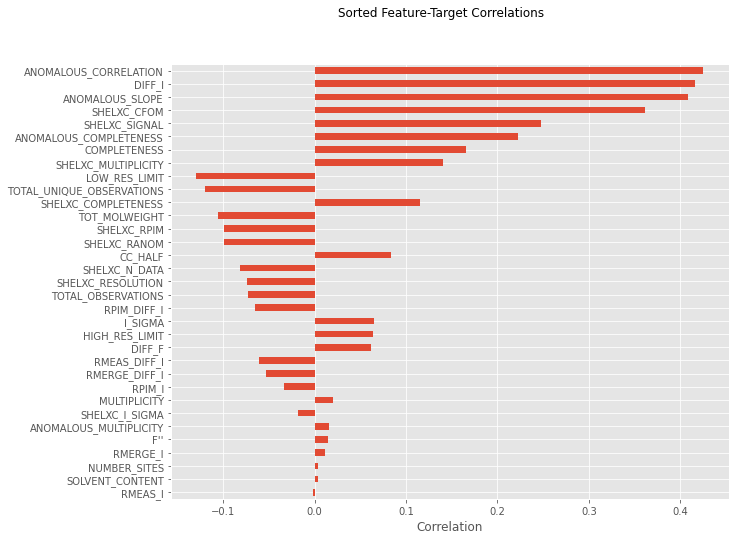

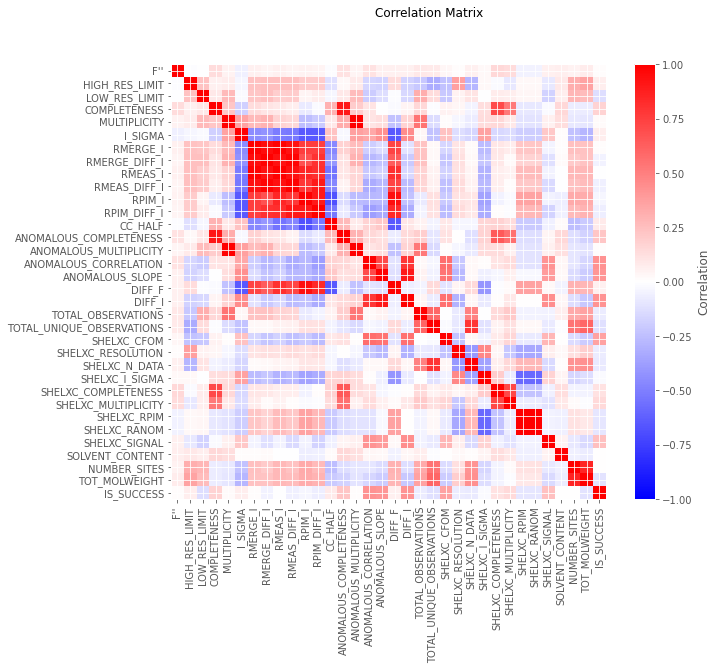

3Dii
------------------------------
Dataset 1
> Success Rate: 50.83%


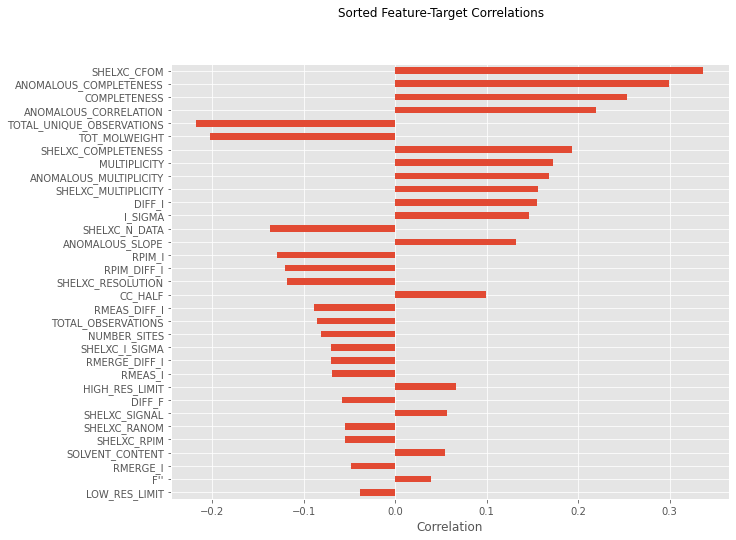

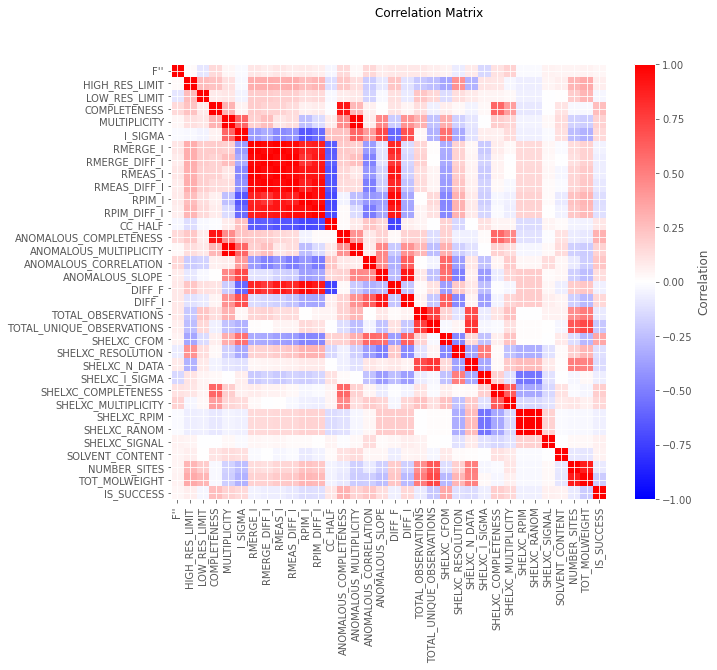

In [4]:
from matplotlib.colors import CenteredNorm


for db_kind, datum in data.items():
    print(db_kind.title())
    x, y, union = datum.unpack(drop_col=["SPACEGROUP", "DATASET_id", "RESOLUTION_LOW", "RESOLUTION_HIGH"], union=True)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, union = x[mask], y[mask], union[mask]
    union = union.drop("DATASET_NAME", axis=1)
    x = x.drop("DATASET_NAME", axis=1)
    
    # print info
    print(f"{'-' * 30}\n"
      f"Dataset {i}\n"
      f"> Success Rate: {y.sum()/y.size:.2%}")
    
    # show correlation with target
    corr_target = x.corrwith(y)
    corr_target_sorted = corr_target.sort_values(key=lambda k: abs(k))
    figsize = (10, 8)
    corr_target_sorted.plot.barh(figsize=figsize)
    plt.savefig(fr"../figures/correlation_target_{db_kind}_untouched.png")
    
    # labels
    plt.xlabel("Correlation")
    plt.suptitle("Sorted Feature-Target Correlations")
    #plt.savefig(fr"../figures/correlation_target_{db_kind}_untouched.png")
    plt.show()
    
    # show correlation matrix
    corr = union.corr()
    plt.imshow(corr, cmap="bwr", norm=CenteredNorm())
    plt.gcf().set_size_inches(*figsize)
    plt.colorbar(label="Correlation")

    # labels and ticks
    plt.xticks(range(union.columns.size), union.columns, rotation=90)
    plt.yticks(range(union.columns.size), union.columns)
    plt.suptitle(f"Correlation Matrix")

    # save results
    #plt.savefig(fr"../figures/correlation_matrix_{db_kind}_untouched.png")
    plt.show()

Regarding feature-target correlations:

- **Dials** (~33% success rate):
    - 3 dominant features, **anomalous correlation/slope** (highly inter-correlated) and **DIFF I**
    - Closely followed by **SHELXC CFOM**
    - Then **SHELXC signal** and **(anomalous) completeness**
- **XDS** (~50% success rate):
    - Dominated by **SHELXC CFOM**
    - Followed by **(anomalous/SHELXC) completeness/multiplicity**, **anomalous correlation**, **total unique observations** and **total molecular weight**
- Both:
    - DIALS correlation magnitudes **larger** than those of XDS
    - **SHELXC CFOM** with very high correlations
    - **f''** and **solvent content** among the lowest correlations
    - Highly inter-correlated cluster (**RMERGE/RMEAS/RPIM (DIFF) I** average-low correlations


The following features have noticeable inter-correlation:

- **RMERGE/RMEAS/RPIM (DIFF) I** are all extremely correlated with each other
- The above are also highly anti-correlated with **I SIGMA** and **CC HALF**, which aren't correlated with each other
- **DIFF F** is highly correlated with all of the mentioned so far
- Following pairs appear very highly correlated with each other:
    - **Anomalous slope/correlation** (DIALS only), relevant since these are among the dominant features in target correlation (also on DIALS)
    - **SHELXC RPIM/RANOM**
    - **Total (unique) observations**
    - **Number of sites** and **total molecular weight**
- **Completeness/Multiplicity** are highly correlated with their respective anomalous/SHELXC versions (and slightly with each other), as expected


Now try to see weighted mean of feature-target correlations of every dataset, using the respective success rate as weights, meaning that the most successfull groups will be more impactful in the final table.

Dials
> Datasets with NaN correlations with target: [7, 27, 47]


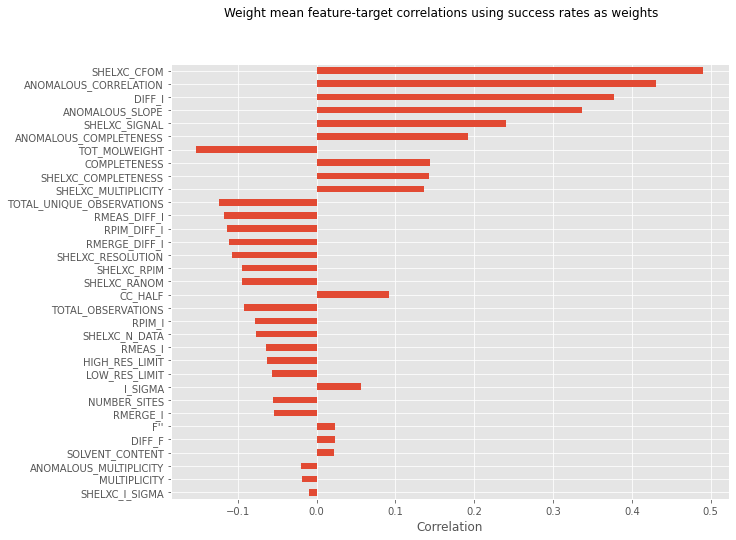

------------------------------------------------------------
3Dii
> Datasets with NaN correlations with target: []


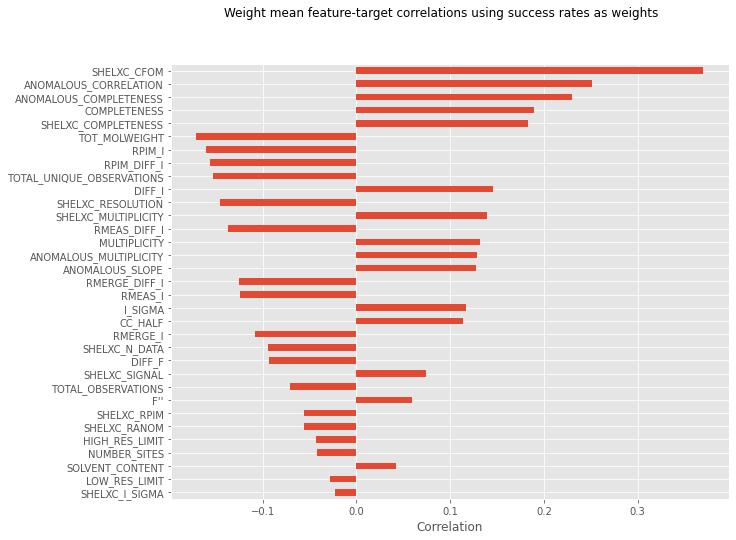

------------------------------------------------------------


In [5]:
lows, highs = ["OG", 80, 60, 40, 20, 18, 16, 14, 12, 10], ["OG", 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7]


for db_kind, datum in data.items():
    print(db_kind.title())
    x, y = datum.unpack(drop_col=["SPACEGROUP", "DATASET_id"])
    
    # get low/high resolution limits
    res_col_names = ["DATASET_NAME", "RESOLUTION_LOW", "RESOLUTION_HIGH"]
    res_map = x[res_col_names]
    res_map.set_index("DATASET_NAME", inplace=True)
    x = x.drop(res_col_names, axis=1)
    
    # group data
    groups = GroupedData(x, y)
    groups.group(res_map.index)
    
    # sort groups
    names = res_map.index.unique().tolist()
    names.sort()
    groups.sort(names, inplace=True)
    
    # prepare lists for correlation tables and success rates to be used as weights
    correlations, nas, weights = [], [], []
    
    # for every low/high resolution combination
    for i, group in groups:
        # show general info
        low, high = res_map.loc[i].mean()
        '''print(f"{'-' * 30}\n"
              f"Dataset {i}\n"
              f"> Resolution Limits > Low: {low:.1f}; High: {high:.1f}")'''
        x, y = group.unpack()
        
        # certain failure region exception
        if low < 16 and high > 3:
            weights.append(0)
            correlations.append(np.zeros(shape=(x.columns.size,)))
            #print("Skipped")
            continue
        
        
        # store correlation with target
        corr = x.corrwith(y)
        
        if corr.isna().all():
            #print(f"DATASET {i} has only NaN correlations")
            correlations.append(np.zeros_like(corr))
            nas.append(i)
            weights.append(0)
        else:
            # store success rate as weight
            correlations.append(corr.values)
            weights.append(y.sum()/y.size)
        
    
    
    # reshape as dataframe and create weighted average of correlations
    print(f"> Datasets with NaN correlations with target: {nas}")
    correlations = pd.DataFrame(correlations, index=names, columns=x.columns)
    corr_weighted = pd.Series(np.average(correlations, weights=weights, axis=0), index=correlations.columns)
    corr_weighted_sorted = corr_weighted.sort_values(key=lambda k: abs(k))
    
    # show correlations
    corr_weighted_sorted.plot.barh(figsize=(10, 8))
    plt.xlabel("Correlation")
    plt.suptitle("Weight mean feature-target correlations using success rates as weights")
    
    # show results
    plt.savefig(fr"../figures/correlation_target_{db_kind}_weighted.png")
    plt.show()
    print("-"*60)

Results generally agree with those for the 'untouched' dataset, with a few exceptions:

- **SHELXC CFOM** dominates both databases, being followed by **anomalous correlation**
- **Completeness** (and variations) and **total molecular weight** with high target correlations
- **RPIM (DIFF) I** following the above in XDS, unlike its other counterparts (RMERGE/RMEAS)


## Feature Importance

Now use decision trees to obtain feature importance. Start off by finding best features using RandomizedSearch.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint


for db_kind, datum in data.items():
    print(db_kind.upper())
    x, y = datum.unpack(drop_col=["DATASET_id"])

    '''# take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y = x[mask], y[mask]
    x = x.drop("DATASET_NAME", axis=1)'''
    
    # take only optimal data
    mask = np.isclose(x["RESOLUTION_HIGH"], 2.5, atol=.1)
    x, y = x[mask], y[mask]
    x = x.drop("RESOLUTION_HIGH", axis=1)
    
    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP"] = x["SPACEGROUP"].map(spc_grp_map)

    #drop NaN
    mask_nan = x.isna().any(axis=1)
    x, y = x[~mask_nan], y[~mask_nan]
    
    
    # split train/test datasets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, stratify=y)
    
    # set up randomized search
    param_rand = {"tree__class_weight": [None, "balanced"],
                  "tree__criterion": ["gini", "entropy"], #metric to judge reduction of impurit
                  "tree__max_features": randint(2, len(X_train.columns)+1), #max number of features when splitting
                  "tree__min_samples_split": randint(2, 20+1), #min samples per node to induce split
                  "tree__max_depth": randint(5, 20+1), #max number of splits to do
                  "tree__min_samples_leaf": randint(1, 20+1), #min number of samples in a leaf; may set to 1 anyway
                  "tree__max_leaf_nodes": randint(10, 40+1)} #max number of leaves
    
    # run randomized search
    tree = DecisionTreeClassifier()
    pipe = Pipeline([("scaler", StandardScaler()), ("tree", tree)])
    rand_search = RandomizedSearchCV(pipe, param_rand, n_iter=10, cv=5, scoring="f1", n_jobs=3)
    rand_search.fit(X_train, y_train)
    
    # prepare results
    best_params = pd.Series(rand_search.best_params_)
    topfeat = pd.Series(rand_search.best_estimator_['tree'].feature_importances_, index=X_train.columns)
    topfeat_sorted = topfeat.sort_values(ascending=False, key=lambda k: abs(k))
    
    print(f"> Best parameters:\n{best_params}\n"
          f"> Best F1 score: {rand_search.best_score_:.2%}\n"
          f"> Feature importances:\n{topfeat_sorted}")
    #print(rand_search.best_params_, rand_search.best_score_, rand_search.best_estimator_)
    
    
    print("-"*60)

DIALS
> Best parameters:
tree__class_weight         None
tree__criterion            gini
tree__max_depth              11
tree__max_features           33
tree__max_leaf_nodes         33
tree__min_samples_leaf       11
tree__min_samples_split      13
dtype: object
> Best F1 score: 90.37%
> Feature importances:
SHELXC_CFOM                  0.630158
SOLVENT_CONTENT              0.065885
TOT_MOLWEIGHT                0.060952
TOTAL_OBSERVATIONS           0.049973
DIFF_I                       0.046822
I_SIGMA                      0.022633
ANOMALOUS_COMPLETENESS       0.019243
SHELXC_SIGNAL                0.018221
NUMBER_SITES                 0.017651
ANOMALOUS_SLOPE              0.012376
DIFF_F                       0.010924
ANOMALOUS_MULTIPLICITY       0.009923
SHELXC_I_SIGMA               0.009544
SHELXC_RANOM                 0.009041
RMEAS_DIFF_I                 0.008660
RMERGE_DIFF_I                0.007997
SHELXC_N_DATA                0.000000
SHELXC_RPIM                  0.000000
SHELXC

ENCODE SPACEGROUP IN PREVIOUS ANALYSIS - MIGHT GIVE USEFUL INSIGHT

In [6]:
from grouping import cluster_spacegroups


x, y, union = data["dials"].unpack(union=True)


n_clusters = 4
_, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
print(x["SPACEGROUP"], x["SPACEGROUP"].map(spc_grp_map))

id
1           P62
2           P62
3           P62
4           P62
5           P62
          ...  
121376    C2221
121377    C2221
121378    C2221
121379    C2221
121380    C2221
Name: SPACEGROUP, Length: 118979, dtype: category
Categories (54, object): ['C121', 'C222', 'C2221', 'F4132', ..., 'P622', 'P6222', 'P63', 'P6322'] id
1         3
2         3
3         3
4         3
5         3
         ..
121376    2
121377    2
121378    2
121379    2
121380    2
Name: SPACEGROUP, Length: 118979, dtype: int64
